Importing some required Libraries

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectFromModel
from scipy.stats import iqr

Importing the dataset

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Mounted at /content/gdrive


In [ ]:
loan_data=pd.read_csv("gdrive/My Drive/BITCOIN/train.csv")

In [ ]:
loan_data

,Loan_ID,Loan_Amount_Requested,Length_Employed,Home_Owner,Annual_Income,Income_Verified,Purpose_Of_Loan,Debt_To_Income,Inquiries_Last_6Mo,Number_Open_Accounts,Total_Accounts,Gender,Interest_Rate
0,10156551,18375,6,1,95000.0,2,1,21.45,3,17,28,1,3.0
1,10115057,4000,3,4,-1.0,2,2,21.64,0,18,33,0,2.0
2,10030395,15000,10,1,83000.0,2,2,22.90,3,11,44,1,3.0
3,10158544,27500,10,0,100000.0,1,2,9.66,0,5,14,1,2.0
4,10117658,9450,-1,5,28000.0,0,1,34.89,1,9,24,0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
131442,10116135,5700,0,1,32000.0,0,2,31.16,1,7,8,1,3.0
131443,10123610,7400,0,5,-1.0,0,1,8.85,0,6,14,1,1.0
131444,10039371,19400,6,5,58000.0,2,2,30.33,1,9,51,0,2.0
131445,10069944,21000,10,0,83000.0,2,2,21.69,1,11,21,1,1.0


Going through the dataset

In [ ]:
loan_data.describe()

,Loan_ID,Loan_Amount_Requested,Length_Employed,Home_Owner,Annual_Income,Income_Verified,Purpose_Of_Loan,Debt_To_Income,Inquiries_Last_6Mo,Number_Open_Accounts,Total_Accounts,Gender,Interest_Rate
count,1.314470e+05,131447.000000,131447.000000,131447.000000,1.314470e+05,131447.000000,131447.000000,131447.000000,131447.000000,131447.000000,131447.000000,131447.000000,131447.000000
mean,1.008209e+07,14340.721355,5.682640,2.168486,6.208692e+04,0.955762,2.644937,17.198859,0.779683,11.189932,25.041895,0.713192,2.156375
std,4.742568e+04,8289.462686,3.827135,2.284534,6.383006e+04,0.822101,2.393371,7.844181,1.031655,4.993654,11.569347,0.452273,0.738183
min,1.000000e+07,500.000000,-1.000000,0.000000,-1.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1.000000
25%,1.004103e+07,8000.000000,2.000000,0.000000,3.500000e+04,0.000000,2.000000,11.360000,0.000000,8.000000,17.000000,0.000000,2.000000
50%,1.008206e+07,12000.000000,6.000000,1.000000,5.600000e+04,1.000000,2.000000,16.830000,0.000000,10.000000,23.000000,1.000000,2.000000
75%,1.012311e+07,20000.000000,10.000000,5.000000,8.200000e+04,2.000000,2.000000,22.780000,1.000000,14.000000,32.000000,1.000000,3.000000
max,1.016431e+07,35000.000000,10.000000,5.000000,7.500000e+06,2.000000,13.000000,39.990000,8.000000,62.000000,156.000000,1.000000,3.000000


In [ ]:
loan_data.columns

Index(['Loan_ID', 'Loan_Amount_Requested', 'Length_Employed', 'Home_Owner',
       'Annual_Income', 'Income_Verified', 'Purpose_Of_Loan', 'Debt_To_Income',
       'Inquiries_Last_6Mo', 'Number_Open_Accounts', 'Total_Accounts',
       'Gender', 'Interest_Rate'],
      dtype='object')

Looking for missing values

In [ ]:
features_na=[]
for feature in loan_data.columns:
  if loan_data[feature].isnull().sum()>1:
    features_na.append(feature)

In [ ]:
features_na

[]

Luckily, no missing values :)

Seperating discrete and continous data

In [ ]:
discrete_feature=[feature for feature in loan_data.columns if len(loan_data[feature].unique())<100]
discrete_feature

['Length_Employed',
 'Home_Owner',
 'Income_Verified',
 'Purpose_Of_Loan',
 'Inquiries_Last_6Mo',
 'Number_Open_Accounts',
 'Total_Accounts',
 'Gender',
 'Interest_Rate']

Plotting interest rates as functions of discrete features

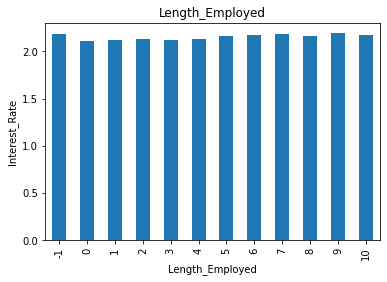

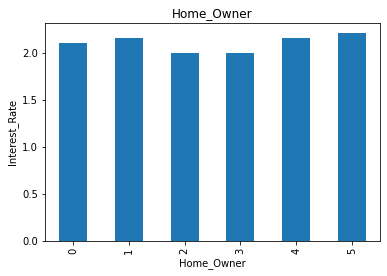

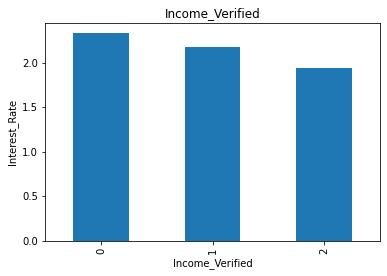

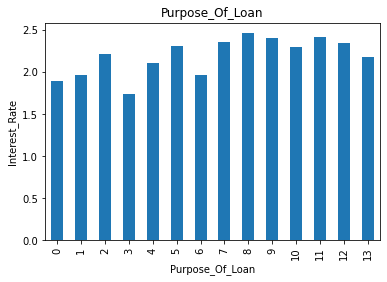

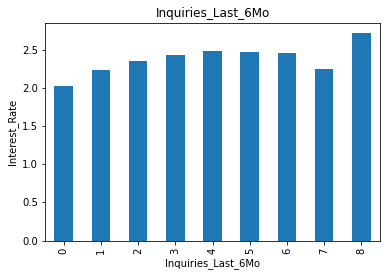

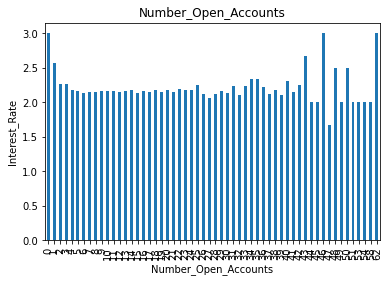

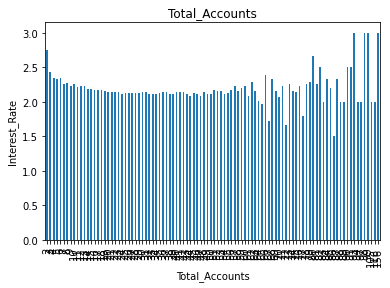

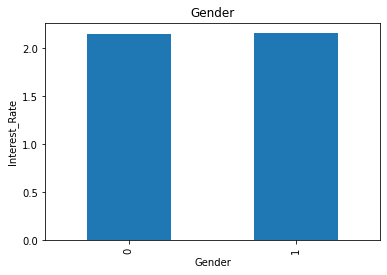

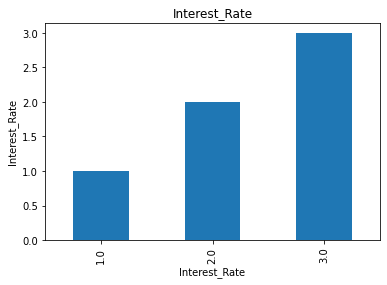

In [ ]:
for feature in discrete_feature:
    data=loan_data.copy()
    data.groupby(feature)['Interest_Rate'].mean().plot.bar()
    plt.xlabel(feature)
    plt.ylabel('Interest_Rate')
    plt.title(feature)
    plt.show()

Plotting continous feature freequency

In [ ]:
continuous_feature=[feature for feature in loan_data.columns if feature not in discrete_feature+['Loan_ID']]
continuous_feature

['Loan_Amount_Requested', 'Annual_Income', 'Debt_To_Income']

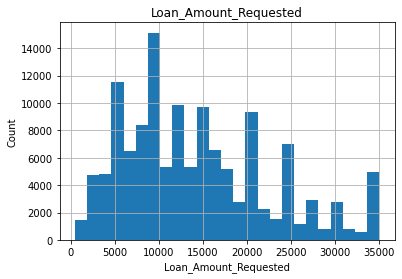

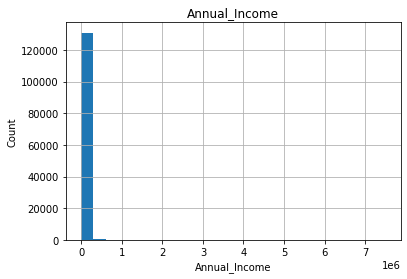

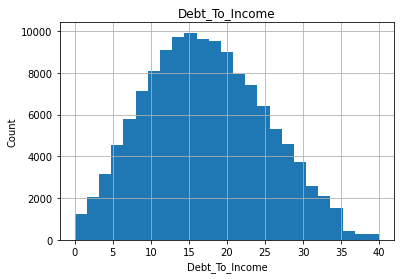

In [ ]:
for feature in continuous_feature:
    data=loan_data.copy()
    data[feature].hist(bins=25)
    plt.xlabel(feature)
    plt.ylabel("Count")
    plt.title(feature)
    plt.show()

To identify variability in continous data features

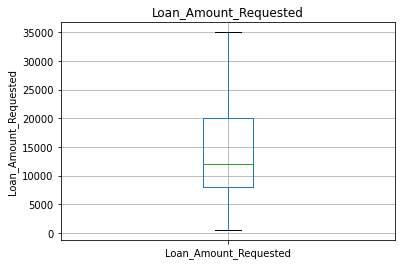

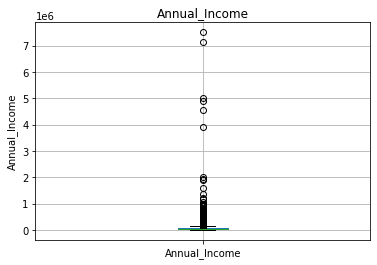

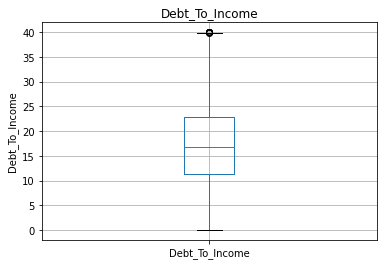

In [ ]:
for feature in continuous_feature:
    data=loan_data.copy()
    data.boxplot(column=feature)
    plt.ylabel(feature)
    plt.title(feature)
    plt.show()

We see annual income has many **outlier** *data* 

#Dealing Invalid Data

Also from plots we see there are meaning less data in the dataframe, length employed and annual salary can't have values equal to -1.0

In [ ]:
error_data_le=loan_data.loc[loan_data["Length_Employed"]<0]
error_data_le

,Loan_ID,Loan_Amount_Requested,Length_Employed,Home_Owner,Annual_Income,Income_Verified,Purpose_Of_Loan,Debt_To_Income,Inquiries_Last_6Mo,Number_Open_Accounts,Total_Accounts,Gender,Interest_Rate
4,10117658,9450,-1,5,28000.0,0,1,34.89,1,9,24,0,2.0
6,10149472,20000,-1,1,0.0,1,2,14.40,0,12,30,0,1.0
17,10140582,9750,-1,0,30000.0,0,2,23.16,0,8,22,1,2.0
23,10058149,9075,-1,1,32000.0,0,2,30.87,0,11,31,0,3.0
30,10010950,6000,-1,1,0.0,0,2,12.13,1,8,15,1,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
131389,10057256,10000,-1,5,24000.0,2,3,1.30,4,3,4,1,2.0
131398,10096546,19750,-1,0,45000.0,0,1,15.63,1,5,17,0,3.0
131399,10098500,7500,-1,4,0.0,0,4,10.28,1,16,49,1,3.0
131412,10079098,9500,-1,0,60000.0,0,2,19.86,0,14,29,1,1.0


In [ ]:
error_data_ai=loan_data.loc[loan_data["Annual_Income"]<0]
error_data_ai

,Loan_ID,Loan_Amount_Requested,Length_Employed,Home_Owner,Annual_Income,Income_Verified,Purpose_Of_Loan,Debt_To_Income,Inquiries_Last_6Mo,Number_Open_Accounts,Total_Accounts,Gender,Interest_Rate
1,10115057,4000,3,4,-1.0,2,2,21.64,0,18,33,0,2.0
8,10095983,1575,0,5,-1.0,2,1,14.54,0,13,24,1,1.0
13,10146078,18000,0,5,-1.0,0,1,10.35,0,10,23,1,1.0
15,10100151,14000,9,4,-1.0,0,2,21.19,1,13,37,0,3.0
22,10038573,11200,4,1,-1.0,0,2,16.88,0,11,37,1,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
131413,10125135,5000,4,5,-1.0,2,2,17.46,0,5,10,1,1.0
131415,10157016,8725,10,0,-1.0,0,9,23.76,0,4,6,1,3.0
131417,10071916,19000,10,0,-1.0,2,2,25.69,0,9,20,1,2.0
131420,10127880,16500,10,5,-1.0,2,2,11.83,1,21,41,0,2.0


The rows with errors are not small, so we replace the error values with median of corresponding column

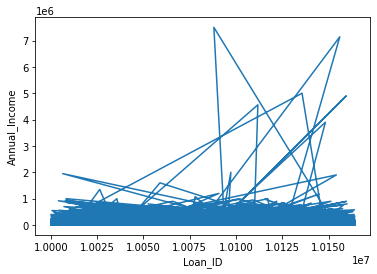

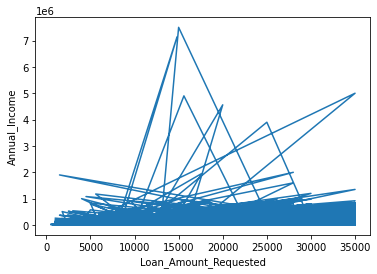

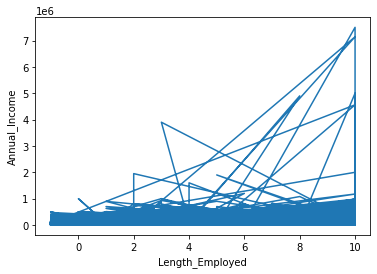

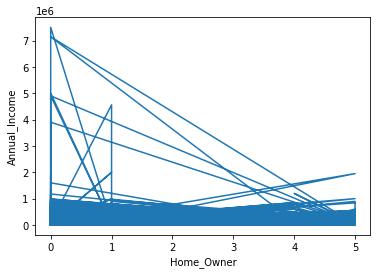

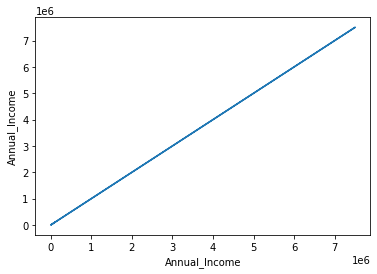

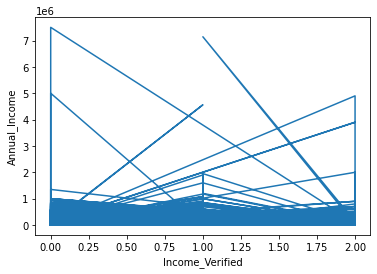

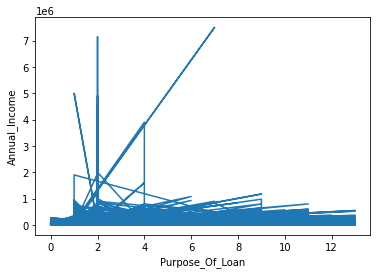

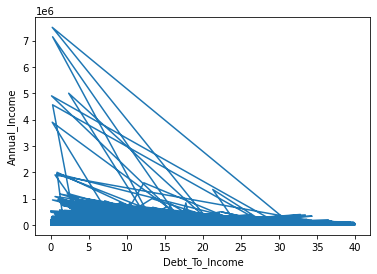

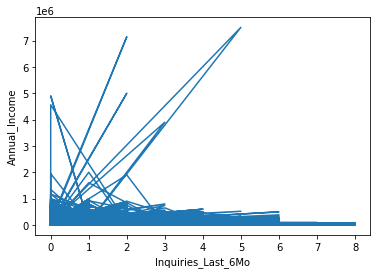

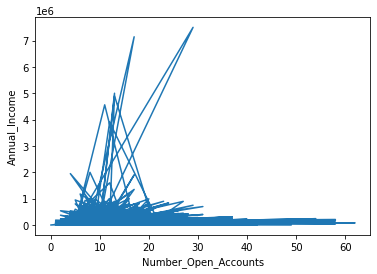

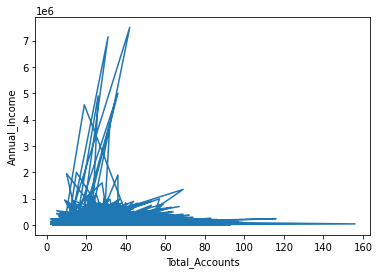

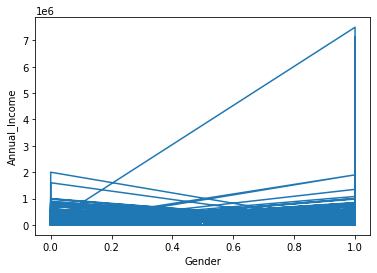

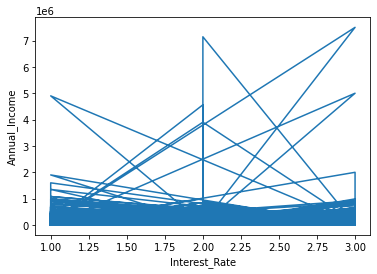

In [ ]:
for x in loan_data.columns:
  plt.plot(loan_data[x],loan_data.Annual_Income)
  plt.xlabel(x)
  plt.ylabel("Annual_Income")
  plt.show()

No clear relation,so let's go with median itself

In [ ]:
median_ai=[]
median_le=[]
for i in [1,2,3]:
  median_ai.append(loan_data.loc[loan_data["Interest_Rate"]==i].Annual_Income.median())
  median_le.append(int(round(loan_data.loc[loan_data["Interest_Rate"]==i].Length_Employed.median())))

In [ ]:
median_ai,median_le

([62000.0, 55000.0, 55000.0], [6, 6, 6])

In [ ]:
loan_data['Length_Employed']=np.where(loan_data['Length_Employed']<0,6,loan_data['Length_Employed'])

In [ ]:
loan_data["Annual_Income"] = np.where(loan_data["Annual_Income"]<0,56e3,loan_data["Annual_Income"])

In [ ]:
loan_data.describe()

,Loan_ID,Loan_Amount_Requested,Length_Employed,Home_Owner,Annual_Income,Income_Verified,Purpose_Of_Loan,Debt_To_Income,Inquiries_Last_6Mo,Number_Open_Accounts,Total_Accounts,Gender,Interest_Rate
count,1.314470e+05,131447.000000,131447.000000,131447.000000,1.314470e+05,131447.000000,131447.000000,131447.000000,131447.000000,131447.000000,131447.000000,131447.000000,131447.000000
mean,1.008209e+07,14340.721355,5.996409,2.168486,7.029321e+04,0.955762,2.644937,17.198859,0.779683,11.189932,25.041895,0.713192,2.156375
std,4.742568e+04,8289.462686,3.542777,2.284534,5.871513e+04,0.822101,2.393371,7.844181,1.031655,4.993654,11.569347,0.452273,0.738183
min,1.000000e+07,500.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1.000000
25%,1.004103e+07,8000.000000,3.000000,0.000000,4.800000e+04,0.000000,2.000000,11.360000,0.000000,8.000000,17.000000,0.000000,2.000000
50%,1.008206e+07,12000.000000,6.000000,1.000000,5.600000e+04,1.000000,2.000000,16.830000,0.000000,10.000000,23.000000,1.000000,2.000000
75%,1.012311e+07,20000.000000,10.000000,5.000000,8.200000e+04,2.000000,2.000000,22.780000,1.000000,14.000000,32.000000,1.000000,3.000000
max,1.016431e+07,35000.000000,10.000000,5.000000,7.500000e+06,2.000000,13.000000,39.990000,8.000000,62.000000,156.000000,1.000000,3.000000


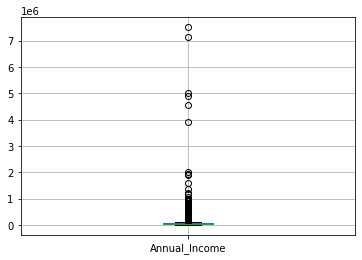

In [ ]:
 loan_data.boxplot("Annual_Income")

Now also variability and ouliers are hight

So let's Use iqr method for remocing outliers

In [ ]:
edit_data=loan_data.copy()

In [ ]:
edit_data.drop(columns=["Loan_ID"],inplace=True)

In [ ]:
for features in continuous_feature:
  iqrange=iqr(edit_data["{}".format(features)])
  edit_data.drop(edit_data[edit_data["{}".format(features)]>((iqrange*1.5)+np.quantile(edit_data["{}".format(features)],0.75))].index,inplace=True)
  edit_data.drop(edit_data[edit_data["{}".format(features)]<((-1.5*iqrange)+np.quantile(edit_data["{}".format(features)],0.25))].index,inplace=True)

In [ ]:
loan_data.shape

(131447, 13)

In [ ]:
edit_data.shape

(123482, 12)

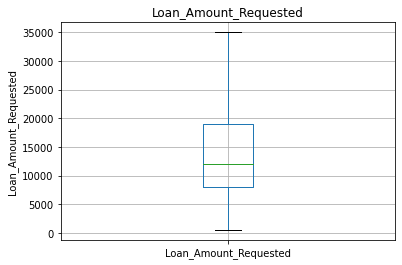

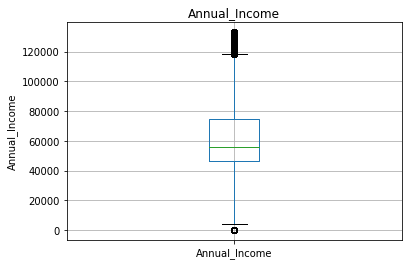

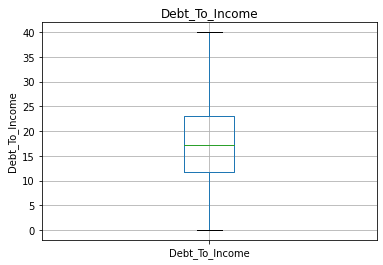

In [ ]:
for feature in continuous_feature:
    data=edit_data.copy()
    data.boxplot(column=feature)
    plt.ylabel(feature)
    plt.title(feature)
    plt.show()

#Preparing for Model

In [ ]:
new_data=edit_data.copy()

From graphs, gender won't much influence interest rate.

In [ ]:
new_data.drop(columns=["Gender"],inplace=True)

In [ ]:
model_data=new_data.copy()

In [ ]:
model_data.shape

(123482, 11)

In [ ]:
X = model_data.iloc[:, 0:10].values
y = model_data.iloc[:, 10].values

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

In [ ]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(x_train)
X_test = sc.transform(x_test)

In [ ]:
acc_model=[]

 # Model 1-XGB

In [ ]:
from xgboost import XGBClassifier

In [ ]:
xgb_clf=XGBClassifier(learning_rate=0.1)

In [ ]:
xgb_clf.fit(x_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [ ]:
y_pred=xgb_clf.predict(x_test)

In [ ]:
from sklearn.metrics import accuracy_score
acc_xgb=accuracy_score(y_pred,y_test)
print(acc_xgb)
acc_model.append(acc_xgb)

0.5267036482163826


#Model 2-SGD

In [ ]:
from sklearn.linear_model import SGDClassifier

In [ ]:
clf =SGDClassifier(max_iter=5000, tol=1e-2)

In [ ]:
clf.fit(X_train,y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=5000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.01,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [ ]:
y_pred=clf.predict(X_test)
acc_sgd=accuracy_score(y_pred,y_test)
print(acc_sgd)
acc_model.append(acc_sgd)

0.5013159493055837


#Model 3-GNB

In [ ]:
from sklearn.naive_bayes import GaussianNB
gnb_clf = GaussianNB()
gnb_clf.fit(X_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [ ]:
y_pred=gnb_clf.predict(X_test)

In [ ]:
print('accuracy is',accuracy_score(y_pred,y_test))

accuracy is 0.4998582823824756


In [ ]:
acc_gnb=accuracy_score(y_pred,y_test)
print(acc_gnb)
acc_model.append(acc_gnb)

0.4998582823824756


In [ ]:
model=["xgb","sgd","gnb"]

##Accuracies of various models

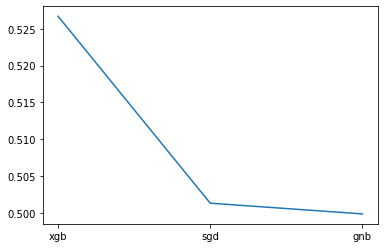

In [ ]:
plt.plot(model,acc_model)

XGB is better model

#Test data

In [ ]:
test_data=pd.read_csv("gdrive/My Drive/BITCOIN/test.csv")

In [ ]:
test_input=test_data.copy()

In [ ]:
test_input.drop(columns=["Loan_ID","Gender"],inplace=True)

In [ ]:
test_input=sc.transform(test_input)

In [ ]:
test_input.describe()

,Loan_Amount_Requested,Length_Employed,Home_Owner,Annual_Income,Income_Verified,Purpose_Of_Loan,Debt_To_Income,Inquiries_Last_6Mo,Number_Open_Accounts,Total_Accounts
count,32862.000000,32862.000000,32862.000000,3.286200e+04,32862.000000,32862.000000,32862.000000,32862.000000,32862.000000,32862.000000
mean,14383.798917,5.666849,2.152334,6.229222e+04,0.947264,2.652730,17.240507,0.789757,11.209360,25.170744
std,8251.458922,3.843167,2.278724,5.124208e+04,0.820220,2.403077,7.848718,1.046999,4.984488,11.637392
min,500.000000,-1.000000,0.000000,-1.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
25%,8000.000000,2.000000,0.000000,3.500000e+04,0.000000,2.000000,11.390000,0.000000,8.000000,17.000000
50%,12250.000000,6.000000,1.000000,5.600000e+04,1.000000,2.000000,16.880000,0.000000,10.000000,24.000000
75%,20000.000000,10.000000,5.000000,8.200000e+04,2.000000,2.000000,22.790000,1.000000,14.000000,32.000000
max,35000.000000,10.000000,5.000000,1.200000e+06,2.000000,13.000000,39.990000,8.000000,76.000000,102.000000


In [ ]:
test_input["Annual_Income"] = np.where(test_input["Annual_Income"]<0,56e3,test_data["Annual_Income"])

In [ ]:
test_input["Length_Employed"] = np.where(test_input["Length_Employed"]<0,6,test_data["Length_Employed"])

In [ ]:
test_input

,Loan_Amount_Requested,Length_Employed,Home_Owner,Annual_Income,Income_Verified,Purpose_Of_Loan,Debt_To_Income,Inquiries_Last_6Mo,Number_Open_Accounts,Total_Accounts
0,23000,5,0,130000.0,0,1,16.49,5,23,48
1,16000,10,0,56000.0,2,2,15.95,0,7,22
2,2500,3,5,23000.0,2,2,3.65,0,6,10
3,6625,10,0,53000.0,2,2,31.50,0,9,25
4,9600,8,0,42600.0,0,2,13.18,1,6,11
...,...,...,...,...,...,...,...,...,...,...
32857,10000,10,0,72503.0,2,2,6.89,0,7,20
32858,12000,2,5,125000.0,0,8,10.83,3,16,28
32859,12000,10,0,81232.0,2,2,19.13,0,14,39
32860,19950,10,0,79000.0,1,2,21.70,1,20,41


In [ ]:
test_input=test_input.iloc[:].values

In [ ]:
test_predict=xgb_clf.predict(test_input)

In [ ]:
test_predict

array([3., 2., 2., ..., 2., 3., 2.])

In [ ]:
sgd_pred=pd.DataFrame(test_predict)

In [ ]:
sgd_pred[0].nunique()

3

In [ ]:
sgd_pred=sgd_pred.merge(test_data["Loan_ID"],left_index=True,right_index=True)

In [ ]:
sgd_pred

,0,Loan_ID
0,3.0,10048970
1,2.0,10075715
2,2.0,10090330
3,2.0,10139511
4,2.0,10153644
...,...,...
32857,1.0,10091923
32858,3.0,10128716
32859,2.0,10037200
32860,3.0,10019409


In [ ]:
sgd_pred=sgd_pred.rename(columns={0:"Interest_Rate"})

In [ ]:
sgd_pred=sgd_pred[["Loan_ID",'Interest_Rate']]

In [ ]:
sgd_pred

,Loan_ID,Interest_Rate
0,10048970,3.0
1,10075715,2.0
2,10090330,2.0
3,10139511,2.0
4,10153644,2.0
...,...,...
32857,10091923,1.0
32858,10128716,3.0
32859,10037200,2.0
32860,10019409,3.0


In [ ]:
sgd_pred.to_csv("subXGB4.csv",index=False)